<a href="https://colab.research.google.com/github/mangaorphy/Formative2-Malaria-Diagnosis-CNN-Transfer-Learning-Group-5/blob/main/Group5_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [ ]:
# Importing basic libraries
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Importing the Keras/TensorFlow libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

## Prepare DataSet

### *Download* DataSet

In [ ]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-03 14:54:26--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.111, 3.167.192.56, 3.167.192.32, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   288MB/s    in 1.2s    

2025-10-03 14:54:27 (288 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  sample_data


In [ ]:
# Define the useful paths for data accessibility (updated for local environment)
base_dir = '/content/cell_images'
parasitized_dir = os.path.join(base_dir, 'Parasitized')
uninfected_dir = os.path.join(base_dir, 'Uninfected')

# Create directories for train/validation/test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(f"Base directory: {base_dir}")
print(f"Parasitized images directory: {parasitized_dir}")
print(f"Uninfected images directory: {uninfected_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

# Verify data directories exist
print(f"\nParasitized folder exists: {os.path.exists(parasitized_dir)}")
print(f"Uninfected folder exists: {os.path.exists(uninfected_dir)}")

Base directory: /content/cell_images
Parasitized images directory: /content/cell_images/Parasitized
Uninfected images directory: /content/cell_images/Uninfected
Training directory: /content/cell_images/train
Validation directory: /content/cell_images/validation
Test directory: /content/cell_images/test

Parasitized folder exists: True
Uninfected folder exists: True


In [ ]:
# Data Exploration: Check dataset statistics
print("=== DATASET EXPLORATION ===")

# Count images in each directory
parasitized_files = os.listdir(parasitized_dir)
uninfected_files = os.listdir(uninfected_dir)

# Filter only image files
parasitized_files = [f for f in parasitized_files if f.endswith(('.png', '.jpg', '.jpeg'))]
uninfected_files = [f for f in uninfected_files if f.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total Parasitized images: {len(parasitized_files)}")
print(f"Total Uninfected images: {len(uninfected_files)}")
print(f"Total images: {len(parasitized_files) + len(uninfected_files)}")
print(f"Dataset is balanced: {len(parasitized_files) == len(uninfected_files)}")

=== DATASET EXPLORATION ===
Total Parasitized images: 13779
Total Uninfected images: 13779
Total images: 27558
Dataset is balanced: True



=== PARASITIZED IMAGES ANALYSIS ===


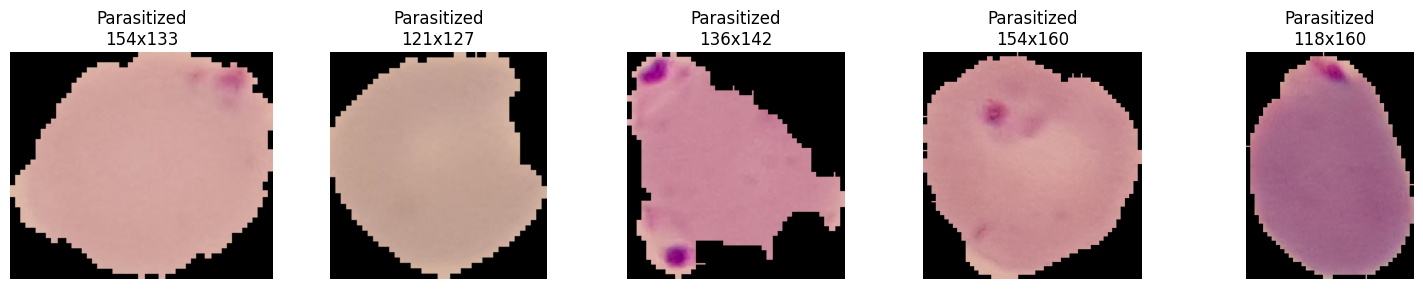

Sample sizes (W x H): [(154, 133), (121, 127), (136, 142), (154, 160), (118, 160)]
Width range: 118 - 154
Height range: 127 - 160

=== UNINFECTED IMAGES ANALYSIS ===


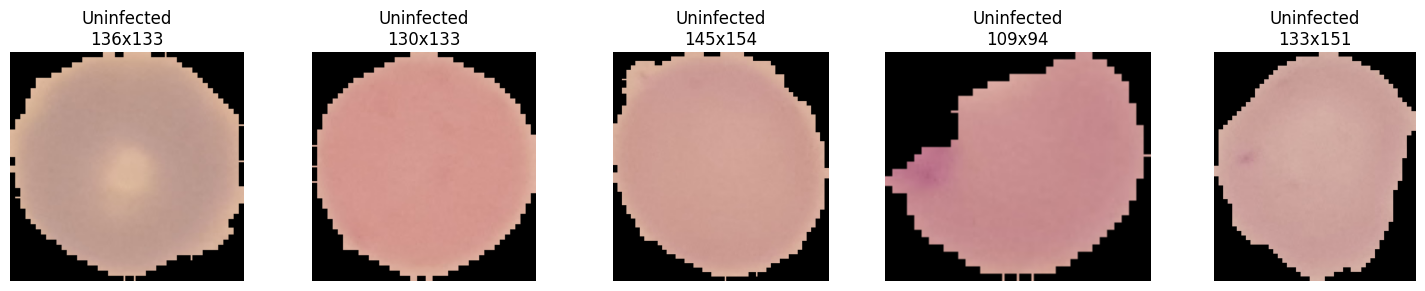

Sample sizes (W x H): [(136, 133), (130, 133), (145, 154), (109, 94), (133, 151)]
Width range: 109 - 145
Height range: 94 - 154


In [ ]:
import shutil

# Analyze image properties and display sample images
def analyze_images(directory, class_name, num_samples=5):
    """Analyze image properties and display samples"""
    print(f"\n=== {class_name.upper()} IMAGES ANALYSIS ===")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    sizes = []

    plt.figure(figsize=(15, 3))

    for i, filename in enumerate(files):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        sizes.append(img.size)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{img.size[0]}x{img.size[1]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print size statistics
    widths = [size[0] for size in sizes]
    heights = [size[1] for size in sizes]

    print(f"Sample sizes (W x H): {sizes}")
    print(f"Width range: {min(widths)} - {max(widths)}")
    print(f"Height range: {min(heights)} - {max(heights)}")

    return sizes

# Analyze both classes
parasitized_sizes = analyze_images(parasitized_dir, "Parasitized")
uninfected_sizes = analyze_images(uninfected_dir, "Uninfected")

Analyzing image dimensions across dataset...

Analyzing all Parasitized image sizes...


Processing Parasitized: 100%|██████████| 1000/1000 [00:00<00:00, 18924.97it/s]



Analyzing all Uninfected image sizes...


Processing Uninfected: 100%|██████████| 1000/1000 [00:00<00:00, 21294.67it/s]


=== IMAGE SIZE STATISTICS ===
Total images analyzed: 2000
Width  - Min: 55, Max: 247, Mean: 132.7
Height - Min: 40, Max: 220, Mean: 132.9


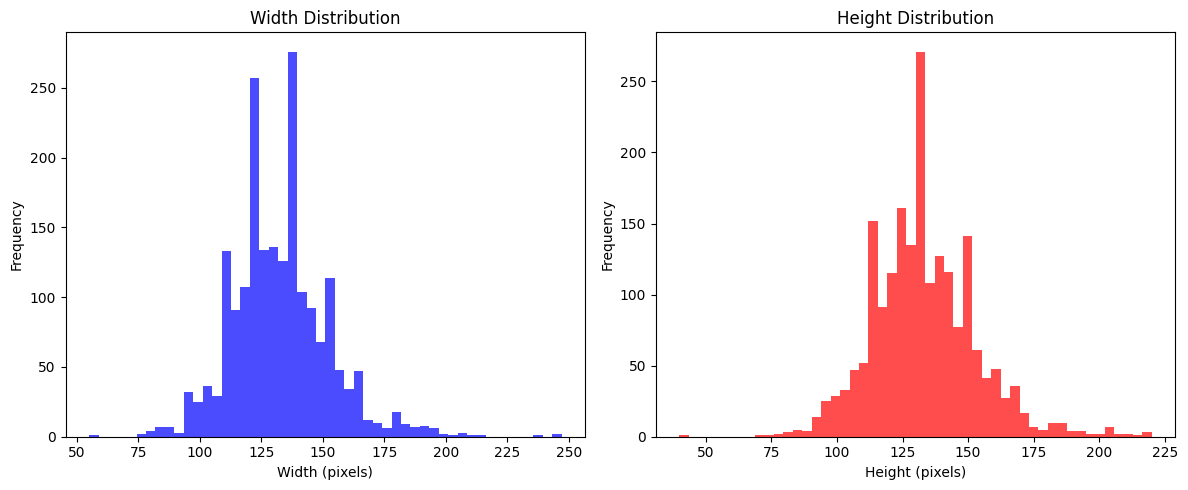

In [ ]:
# Comprehensive image size analysis
def get_all_image_sizes(directory, class_name):
    """Get sizes of all images in directory"""
    print(f"\nAnalyzing all {class_name} image sizes...")

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sizes = []

    for filename in tqdm(files[:1000], desc=f"Processing {class_name}"): # Sample first 1000 for speed
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            sizes.append((img.size[0], img.size[1]))  # (width, height)
            img.close()
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    return sizes

# Analyze image sizes
print("Analyzing image dimensions across dataset...")
parasitized_all_sizes = get_all_image_sizes(parasitized_dir, "Parasitized")
uninfected_all_sizes = get_all_image_sizes(uninfected_dir, "Uninfected")

# Combine and analyze
all_sizes = parasitized_all_sizes + uninfected_all_sizes
widths = [size[0] for size in all_sizes]
heights = [size[1] for size in all_sizes]

print(f"\n=== IMAGE SIZE STATISTICS ===")
print(f"Total images analyzed: {len(all_sizes)}")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, alpha=0.7, color='blue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, alpha=0.7, color='red')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Data Preprocessing and Train/Test Split

In [ ]:
# Configuration for data preprocessing
IMG_SIZE = 64  # Standard size for malaria cell images
BATCH_SIZE = 32
TRAIN_SPLIT = 0.7  # 70% for training
VAL_SPLIT = 0.15   # 15% for validation
TEST_SPLIT = 0.15  # 15% for testing

print(f"Image target size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Data splits - Train: {TRAIN_SPLIT*100}%, Val: {VAL_SPLIT*100}%, Test: {TEST_SPLIT*100}%")

# Create directories if they don't exist
def create_directories():
    dirs_to_create = [
        train_dir, val_dir, test_dir,
        os.path.join(train_dir, 'Parasitized'),
        os.path.join(train_dir, 'Uninfected'),
        os.path.join(val_dir, 'Parasitized'),
        os.path.join(val_dir, 'Uninfected'),
        os.path.join(test_dir, 'Parasitized'),
        os.path.join(test_dir, 'Uninfected')
    ]

    for directory in dirs_to_create:
        os.makedirs(directory, exist_ok=True)
        print(f"Created/verified directory: {directory}")

create_directories()

Image target size: 64x64
Batch size: 32
Data splits - Train: 70.0%, Val: 15.0%, Test: 15.0%
Created/verified directory: /content/cell_images/train
Created/verified directory: /content/cell_images/validation
Created/verified directory: /content/cell_images/test
Created/verified directory: /content/cell_images/train/Parasitized
Created/verified directory: /content/cell_images/train/Uninfected
Created/verified directory: /content/cell_images/validation/Parasitized
Created/verified directory: /content/cell_images/validation/Uninfected
Created/verified directory: /content/cell_images/test/Parasitized
Created/verified directory: /content/cell_images/test/Uninfected


In [ ]:
# Function to split data into train/validation/test sets
def split_and_copy_data():
    """Split data and copy to respective directories"""

    # Get all image files for each class
    parasitized_files = [f for f in os.listdir(parasitized_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Splitting {len(parasitized_files)} parasitized images...")
    print(f"Splitting {len(uninfected_files)} uninfected images...")

    # Shuffle the files
    parasitized_files = shuffle(parasitized_files, random_state=42)
    uninfected_files = shuffle(uninfected_files, random_state=42)

    def split_files(files, class_name):
        """Split files for a single class"""
        n_total = len(files)
        n_train = int(n_total * TRAIN_SPLIT)
        n_val = int(n_total * VAL_SPLIT)

        train_files = files[:n_train]
        val_files = files[n_train:n_train + n_val]
        test_files = files[n_train + n_val:]

        print(f"{class_name} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        return train_files, val_files, test_files

    # Split files for each class
    para_train, para_val, para_test = split_files(parasitized_files, "Parasitized")
    uninf_train, uninf_val, uninf_test = split_files(uninfected_files, "Uninfected")

    # Copy files to respective directories
    def copy_files(file_list, source_dir, dest_dir, class_name, split_name):
        """Copy files from source to destination"""
        dest_class_dir = os.path.join(dest_dir, class_name)

        for filename in tqdm(file_list, desc=f"Copying {class_name} {split_name}"):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_class_dir, filename)

            # Only copy if destination doesn't exist
            if not os.path.exists(dst_path):
                shutil.copy2(src_path, dst_path)

    # Copy all files
    copy_files(para_train, parasitized_dir, train_dir, 'Parasitized', 'train')
    copy_files(para_val, parasitized_dir, val_dir, 'Parasitized', 'val')
    copy_files(para_test, parasitized_dir, test_dir, 'Parasitized', 'test')

    copy_files(uninf_train, uninfected_dir, train_dir, 'Uninfected', 'train')
    copy_files(uninf_val, uninfected_dir, val_dir, 'Uninfected', 'val')
    copy_files(uninf_test, uninfected_dir, test_dir, 'Uninfected', 'test')

    print("Data splitting complete!")

    return {
        'train': {'parasitized': len(para_train), 'uninfected': len(uninf_train)},
        'val': {'parasitized': len(para_val), 'uninfected': len(uninf_val)},
        'test': {'parasitized': len(para_test), 'uninfected': len(uninf_test)}
    }

# Execute the splitting (only if directories are empty)
train_para_dir = os.path.join(train_dir, 'Parasitized')
if len(os.listdir(train_para_dir)) == 0:
    print("Performing data split...")
    split_stats = split_and_copy_data()
    print(f"\nFinal split statistics: {split_stats}")
else:
    print("Data already split, skipping...")

Data already split, skipping...


In [ ]:
# Define the image preprocessing function for tf.data pipeline
def load_image_and_label(file_path, label):
    """Load and preprocess an image file with its label"""
    # Read the image file
    image = tf.io.read_file(file_path)

    # Decode as JPEG (most malaria images are JPEG format)
    image = tf.image.decode_jpeg(image, channels=3)

    # Set the shape explicitly (this is important for tf.data pipeline)
    image.set_shape([None, None, 3])

    # Resize to target size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    # Convert to float and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert label to float32
    label = tf.cast(label, tf.float32)

    return image, label

print("✓ Image preprocessing function defined")

✓ Image preprocessing function defined


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


## Baseline CNN model architecture - Withe 3 Convolutional Layers and a Dense Layer

In [ ]:
# Define the baseline CNN model architecture
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Convolutional Layer 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization()) # Add Batch Normalization

# Flatten the output from the convolutional layers
model.add(Flatten())

# Dense Layer 1
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5)) # Add Dropout for regularization

# Output Layer
model.add(Dense(units=1, activation='sigmoid')) # Using sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,225 (2.61 MB)

 Trainable params: 683,777 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Prepare data with `tf.data`

Create `tf.data` datasets for training, validation, and testing, including mapping for image loading and resizing, shuffling, and prefetching.


In [ ]:
# 2. Create lists of file paths and labels (re-running this section to fix the error)
def create_file_list_and_labels(directory, label):
    """Creates lists of file paths and labels for a given directory and label."""
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    labels = [label] * len(file_paths)
    return file_paths, labels

# Get file paths and labels for each class and split
parasitized_train_files, parasitized_train_labels = create_file_list_and_labels(os.path.join(train_dir, 'Parasitized'), 1)
uninfected_train_files, uninfected_train_labels = create_file_list_and_labels(os.path.join(train_dir, 'Uninfected'), 0)

parasitized_val_files, parasitized_val_labels = create_file_list_and_labels(os.path.join(val_dir, 'Parasitized'), 1)
uninfected_val_files, uninfected_val_labels = create_file_list_and_labels(os.path.join(val_dir, 'Uninfected'), 0)

parasitized_test_files, parasitized_test_labels = create_file_list_and_labels(os.path.join(test_dir, 'Parasitized'), 1)
uninfected_test_files, uninfected_test_labels = create_file_list_and_labels(os.path.join(test_dir, 'Uninfected'), 0)

# Combine file paths and labels for each split (Corrected concatenation for val_files and test_files)
train_files = parasitized_train_files + uninfected_train_files
train_labels = parasitized_train_labels + uninfected_train_labels

val_files = parasitized_val_files + uninfected_val_files
val_labels = parasitized_val_labels + uninfected_val_labels

test_files = parasitized_test_files + uninfected_test_files
test_labels = parasitized_test_labels + uninfected_test_labels

# 3. Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))

# 4. Map the loading and preprocessing function
train_dataset = train_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

# 5. Shuffle the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_files))

# 6. Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 7. Apply prefetching
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("tf.data datasets created and preprocessed successfully.")
print(f"Train dataset: {train_dataset}")
print(f"Validation dataset: {val_dataset}")
print(f"Test dataset: {test_dataset}")

tf.data datasets created and preprocessed successfully.
Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


##Train the model

Train the baseline CNN model using the `tf.data` datasets.


In [ ]:
# 1. Define the number of training epochs.
EPOCHS = 15

# 2. Train the model using the .fit() method
# 3. Store the training history in a variable
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7477 - loss: 0.5722 - val_accuracy: 0.8141 - val_loss: 0.4130
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.9364 - loss: 0.1861 - val_accuracy: 0.9109 - val_loss: 0.2168
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9496 - loss: 0.1526 - val_accuracy: 0.9509 - val_loss: 0.1538
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9525 - loss: 0.1496 - val_accuracy: 0.9511 - val_loss: 0.1312
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9563 - loss: 0.1311 - val_accuracy: 0.9547 - val_loss: 0.1434
Epoch 6/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9600 - loss: 0.1203 - val_accuracy: 0.9569 - val_loss: 0.1370
Epoch 7/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9623 - loss: 0.1124 - val_accuracy: 0.9448 - val_loss: 0.1567
Epoch 8/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9648 - loss: 0.1025 - 

##Model Evaluation and Comparison

In [ ]:
# Evaluation functions for comprehensive analysis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_model_comprehensive(model, test_dataset, model_name="Model"):
    """
    Comprehensive model evaluation with metrics and visualizations
    """
    print(f"\n{'='*60}")
    print(f"🔍 EVALUATING {model_name.upper()}")
    print(f"{'='*60}")

    # Get predictions
    print("Generating predictions...")
    y_true = []
    y_pred_proba = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred_proba.extend(predictions.flatten())

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Test Loss: {test_loss:.4f}")

    # Classification report
    print(f"\n📋 CLASSIFICATION REPORT:")
    class_names = ['Uninfected', 'Parasitized']
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Training History (if available)
    if 'history' in globals() and history is not None:
        ax1 = axes[0]
        ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax1.set_title(f'{model_name} - Training History', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'Training History\nNot Available',
                    ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
        axes[0].set_title(f'{model_name} - Training History', fontweight='bold')

    # 2. Confusion Matrix
    ax2 = axes[1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=class_names, yticklabels=class_names)
    ax2.set_title(f'{model_name} - Confusion Matrix', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    # 3. ROC Curve
    ax3 = axes[2]
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title(f'{model_name} - ROC Curve', fontweight='bold', fontsize=12)
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return metrics for comparison
    return {
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


Baseline CNN Model Evaluation

🔍 EVALUATING BASELINE CNN
Generating predictions...

📊 PERFORMANCE METRICS:
   Test Accuracy: 0.9570
   Test Loss: 0.1690

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Uninfected     0.9449    0.9705    0.9575      2068
 Parasitized     0.9697    0.9434    0.9564      2068

    accuracy                         0.9570      4136
   macro avg     0.9573    0.9570    0.9570      4136
weighted avg     0.9573    0.9570    0.9570      4136



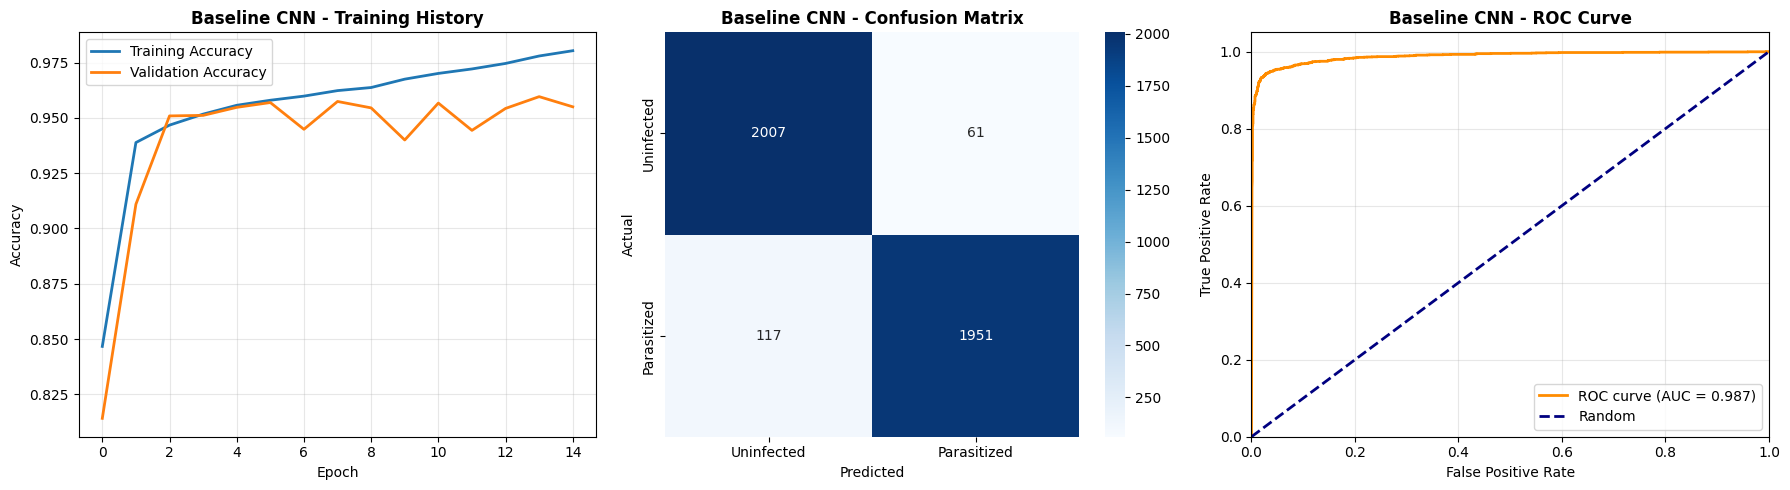

In [ ]:
# EXPERIMENT 1: Evaluate the baseline model (already trained)
print("Baseline CNN Model Evaluation")
exp1_results = evaluate_model_comprehensive(model, test_dataset, "Baseline CNN")

Results: Baseline CNN Model Evaluation

The evaluation of the baseline CNN model on the test dataset yielded the following results:

*   **Test Accuracy:** 0.9570 - This indicates that the model correctly classified approximately 95.70% of the test images.
*   **Test Loss:** 0.1690 - This is a measure of the model's error on the test set, with lower values indicating better performance.

**Classification Report**

*   **Precision:** For 'Uninfected', the precision is 0.9449, meaning that when the model predicted 'Uninfected', it was correct 94.49% of the time. For 'Parasitized', the precision is 0.9697.
*   **Recall:** For 'Uninfected', the recall is 0.9705, meaning the model correctly identified 97.05% of all actual 'Uninfected' cases. For 'Parasitized', the recall is 0.9434.
*   **F1-score:** The F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance for each class. The F1-scores are 0.9575 for 'Uninfected' and 0.9564 for 'Parasitized'.
*   **Support:** This is the number of actual instances in each class in the test set (2068 for both).

The **Confusion Matrix** visually represents the model's predictions versus the actual labels:

*   **True Positives (TP):** 1951 (Correctly predicted Parasitized)
*   **True Negatives (TN):** 2007 (Correctly predicted Uninfected)
*   **False Positives (FP):** 61 (Predicted Parasitized, but actually Uninfected)
*   **False Negatives (FN):** 117 (Predicted Uninfected, but actually Parasitized)

The **ROC Curve** and **AUC (Area Under the Curve)** provide an overall measure of the model's ability to distinguish between the two classes. An AUC of 0.987 indicates excellent discriminatory power.
